<a href="https://colab.research.google.com/github/SankaAnushaNYU/intro-to-python/blob/master/Bootcamp_Final_05_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

Questions on which I want to analyze the data are:

During this pandemic due to COVID there are many surfacing issues like economy and supply chain. Along with such tangible attributes, people's emotional wellbeing is also disturbed as they are under going immense pressure, fear and anxiety leading to many suicidal thoughts. Our analysis is an attempt which can predict person's mental state from his tweets, that data can give an edge to act proactively to council or lend help to people. As a society swin through pandemic more healthly!

# Author :- **Anusha, Shreya, Abhijeet**

#Pre-requsite modules required to run the code

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
import tweepy as tw
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

# 1. Data Collection : 
For performing sentiment analysis we need training dataset to tune our   model and test data to predict the emotional state of a person from his tweets.
     

1.   Training data : Dataset with tweets and its sentiment from *src*
2.   Testing data :  Latest tweets using tweetpy



In [ ]:
def import_data(file_path):
  '''
    Input: File path of data set
    Output: Dataframe of csv data 
  '''
  train_data = pd.read_csv(file_path)
  return train_data


In [ ]:
def get_tweets(date_since,search_words):
  '''
    Input: list of dates from which you need tweets and List of search words
    Output: Dataframe of tweets
  '''
  consumer_key =  "T94aK9PaTzpWoIjXe0183v9CS"
  consumer_secret = "jcAu3IZN5zg87hIeBn4Y8qVduVuYpuFcGt1Q8Zl3eW0DFf1FFq"
  access_token = "1245416768732086278-TkeSL69lQQ3duYP6TWuIhsn7bxpZHf"
  access_token_secret = "NTmonA7kMTIZhHYglLA4xYcJxcKezZVg7Otity8plR3LU"

 
  auth = tw.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)
  api = tw.API(auth, wait_on_rate_limit=True)

  tweets_list = []
  for date in date_since:
    # print(keyword,date)
    for keyword in search_words:
      search_key = keyword+' -filter:retweets'
      tweets = tw.Cursor(api.search,q= search_key,count=1000,lang="en",since=date).items(50)
      # users_locs = [[tweet.user.screen_name, tweet.user.location] for tweet in tweets]
      for tweet in tweets:
        tweets_list.append([tweet.id,tweet.created_at,tweet.user.location,tweet.text] )

  return DataFrame(tweets_list)

In [ ]:
train_tweets_dates= ["2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-04-01","2020-06-01","2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01","2020-12-01","2021-01-01","2021-02-01","2021-03-01","2021-04-01"]
train_tweets_search_words = ["Depression","hope","Hopeless","Joy","Quarantine","covid-19", "CORONA", "StayHomeStaySafe", "StayHome","life","family","lonely","god","stocks","NBL","IPL","COVID2019","COVID19","pandemic","","Coronavirus","Social distancing","Flatten the curve", "covid-19", "CORONA", "StayHomeStaySafe", "StayHome", "CovidPandemic", "Lockdown", "Qurantine", "Outbreak"]
train_tweet_data = get_tweets(train_tweets_dates,train_tweets_search_words)
DataFrame(train_tweet_data).to_csv("unprocessed_tweets.csv")
train_tweet_data.columns = ["tweet.id","tweet.created_at","tweet.user.location","tweet.text"]

In [ ]:
url = 'https://raw.githubusercontent.com/Shreya2012/data_bootcamp_final_project/main/unprocessed_tweets.csv'
train_tweet_data = pd.read_csv(url)
train_tweet_data.reset_index()
train_tweet_data.columns = ["index","tweet.id","tweet.created_at","tweet.user.location","tweet.text"]
tweets_list = train_tweet_data.values.tolist()

In [ ]:
train_tweet_data

,index,tweet.id,tweet.created_at,tweet.user.location,tweet.text
0,0,1392916302407233542,2021-05-13 18:55:00,NaN,Depression music https://t.co/gMy9bXz5qD
1,1,1392916267120480260,2021-05-13 18:54:51,NaN,@KieranTop1 “Self diagnosed with depression”. There are actual people fighting for there mental health to be ok and… https://t.co/8MPHRarfbu
2,2,1392916252843200514,2021-05-13 18:54:48,planet earth,"@AnnMill24523296 @ChrisEvans And btw, the kids who really need mental help, are not just dealing with depression or… https://t.co/X7s2pMj7mV"
3,3,1392916243766812675,2021-05-13 18:54:46,"Delray Beach, FL",I got to say I had a little brush with depression during the pandemic. A lot of people blew me off. I got pretty lo… https://t.co/dprARR5AYL
4,4,1392916225701801986,2021-05-13 18:54:41,California,@Em70335551 Therapy won't help with the Epilepsy but not everyone's depression are caused by the same thing that ca… https://t.co/aSMXrL4Dvy
...,...,...,...,...,...
6195,6195,1392914091115696138,2021-05-13 18:46:13,G93 MEnterovirus R53 PVFSCFS,QUESTION: What is M.E.? (Myalgic Encephalomyelitis)\n\nhttps://t.co/HiWDeQvSgW\n\nANSWER: A Brain &amp; Spinal Cord Infecti… https://t.co/LO5p7I7Kx2
6196,6196,1392914087139581960,2021-05-13 18:46:12,"Alabama, USA",@MikeyMo79 @Knick_Cage @bsbeamer @kaitlancollins Remember the “Neanderthal thinking” comment from Biden. Has there… https://t.co/cuYKhBWGlf
6197,6197,1392914085814153217,2021-05-13 18:46:11,NaN,Outbreak https://t.co/OxcsNdXg71
6198,6198,1392913979178209282,2021-05-13 18:45:46,"Calgary AB, and St. John's, NL","The slow but steady increase in daily cases due to travel, tells us that now is the wrong time. Let's skip the next… https://t.co/fxjclsEer3"


# 2. Data Analysis (EDA):
Agenda of this section is to understand the data distribution and variety. This analysis will help us in next step of data cleaning.


1.   Non-visual analysis
  1.   Getting dimensions,data types and null values of the dataset
  2.   Getting data types and null values
  3.   Understanding the data distribution and outliners of float columns
  4.   Categorial variables

2.   Visual analysis
  1.   Word cloud of unprocessed tweets.
  2.   Frequently used words.
  3. Location 


In [ ]:
train_tweet_data.shape

(6200, 5)

In [ ]:
train_tweet_data.columns

Index(['index', 'tweet.id', 'tweet.created_at', 'tweet.user.location',
       'tweet.text'],
      dtype='object')

In [ ]:
train_tweet_data.dtypes

index                   int64
tweet.id                int64
tweet.created_at       object
tweet.user.location    object
tweet.text             object
dtype: object

In [ ]:
train_tweet_data.isnull().sum(axis = 0)

index                     0
tweet.id                  0
tweet.created_at          0
tweet.user.location    1882
tweet.text                0
dtype: int64

In [ ]:
train_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6200 entries, 0 to 6199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                6200 non-null   int64 
 1   tweet.id             6200 non-null   int64 
 2   tweet.created_at     6200 non-null   object
 3   tweet.user.location  4318 non-null   object
 4   tweet.text           6200 non-null   object
dtypes: int64(2), object(3)
memory usage: 242.3+ KB


In [ ]:
train_tweet_data['tweet.user.location'].value_counts()

India                             129
New Delhi, India                   71
Hyderabad, India                   69
United States                      57
Argentina                          48
                                 ... 
Jokerland  she/her                  1
Sulūk                               1
Blessed                             1
Fairytopia                          1
 🇮🇳,भारत,India                      1
Name: tweet.user.location, Length: 1094, dtype: int64

In [ ]:
train_tweet_data['tweet.id'].value_counts()

1392916232068816898    17
1392914482670669829    16
1392912434256441345    16
1392913025703636992    16
1392916303745372168    15
                       ..
1392916314356912134     1
1392916344178307072     1
1392916314310729736     1
1392916324347691016     1
1392916479151153160     1
Name: tweet.id, Length: 2261, dtype: int64

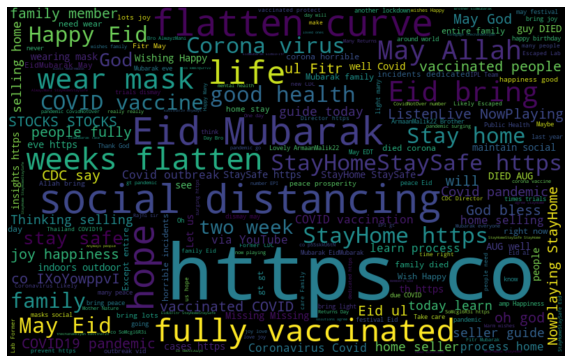

In [ ]:
# Word Cloud of tweets
all_words = ' '.join([text for text in train_tweet_data["tweet.text"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## From word cloud we can see that there are many words like https, CO, US which doesnt convey any emotion - This leads us to remove the stop words for deducing the relavent words.

In [ ]:
# Frequently used words
unique_words = []
words_list = []
for tweet in train_tweet_data["tweet.text"]:
  word_list = tweet.split(" ")
  unique_words = unique_words + word_list
  words_list = words_list + word_list
  unique_words = list(set(unique_words))

unique_word_count = []
for word in unique_words:
  unique_word_count.append([word, words_list.count(word)])
unique_word_count = unique_word_count[3:]
unique_word_count = pd.DataFrame(unique_word_count, columns = ['word', 'count'])
unique_word_count

,word,count
0,tourer,4
1,🌩,4
2,Mind...\nRyan,4
3,Colonial,2
4,@dominic28916478,4
...,...,...
13291,AstraZeneca…,1
13292,@wx_becks,8
13293,https://t.co/EPyPDettUm,4
13294,sweet,1


#3. Data Cleaning:
  1.   Remove null values
  2.   Clean the tweets - remove punctations, stop words, URL and special characters.
  3. Lemmetization & Stemming





In [ ]:
import nltk
import os
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('all')
lemmatizer = WordNetLemmatizer()
stopword_list = stopwords.words("english")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [ ]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()).lower())

def clean_post(post):
    
    global stopword_list, lemmatizer         
    post_tokens = word_tokenize(post)
    filtered_tokens = [token for token in post_tokens if token not in stopword_list]
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in filtered_tokens]
    return " ".join(lemmas)

def cleantweets(tweets_list):
  # Clean the tweets - remove punctations, stop words, URL and special characters. 
  cleaned_tweet = []
  for tweet in tweets_list:
    cleaned_tweet.append(clean_tweet(tweet))

  # Lemmetization & Stemming of tweets
  clean_post_tweet = []
  for tweet in cleaned_tweet:
    clean_post_tweet.append(clean_post(tweet))  

  return clean_post_tweet

In [ ]:
# getting cleaned tweets and saving the data into csv as DataFrame
train_tweet_data["Cleaned_Tweets"] = cleantweets(train_tweet_data["tweet.text"])
train_tweet_data.drop_duplicates(subset ="Cleaned_Tweets",keep = False, inplace = True)
tweets_cleaned = pd.DataFrame(train_tweet_data)
# tweets_cleaned.to_csv('tweets_cleaned.csv')
tweets_cleaned

,index,tweet.id,tweet.created_at,tweet.user.location,tweet.text,Cleaned_Tweets
48,48,1392915563148611590,2021-05-13 18:52:04,NaN,Depression is not just a feeling..\nIt's not something people enter by choice and can come out from by choice.\n\nSome… https://t.co/t8Rq0qurIu,depression feel something people enter choice come choice
49,49,1392915523680317440,2021-05-13 18:51:54,"Karen, Kenya",How does depression get us here in Kenya with all these 🤣🤣🤣? https://t.co/xjXujctTZN,depression get us kenya
50,50,1392916315313098752,2021-05-13 18:55:03,"Dadri, India",@rjogpal @dccharkhidadri @DadriPolice @diprodadri Sir u r doing great work... that much transparency gives hope to… https://t.co/oIjxtEL8zK,sir u r great work much transparency give hope
51,51,1392916314876956673,2021-05-13 18:55:03,NaN,@NataBiden your wishes are all right and i hope they're fulfiled,wish right hope fulfil
52,52,1392916313761226754,2021-05-13 18:55:02,check out my archive!!,I hope he's doing fine,hope fine
...,...,...,...,...,...,...
6050,6050,1392916513112342534,2021-05-13 18:55:50,"Windsor, Ontario",And here we are. With three more weeks of lockdown. https://t.co/g62DiaLMl6,three weeks lockdown
6051,6051,1392916508938883077,2021-05-13 18:55:49,NaN,Sexy Thai Girls Soi 6 Lockdown Stream Pattaya Thailand Livestream Pattaya IRL https://t.co/QCt8SaMoyK,sexy thai girls soi 6 lockdown stream pattaya thailand livestream pattaya irl
6052,6052,1392916482401751041,2021-05-13 18:55:43,NaN,@PaulJSweeney @PeterAdamSmith @NicolaSturgeon @STVNews what you saying about this? Encouraged by and MSP to break… https://t.co/QuZ2SgxCuj,say encourage msp break
6053,6053,1392916479251681280,2021-05-13 18:55:42,"Nashville, TN",@queenomh13 “What died didn’t stay dead” i got my first job in the lockdown 🥲🥲🥲\n@fearlesstvlyric @DisneySwiftie,die stay dead get first job lockdown


In [ ]:
tweets_cleaned.isnull().sum(axis = 0)

index                    0
tweet.id                 0
tweet.created_at         0
tweet.user.location    380
tweet.text               0
Cleaned_Tweets           0
dtype: int64

In [ ]:
tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 48 to 6055
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                1045 non-null   int64 
 1   tweet.id             1045 non-null   int64 
 2   tweet.created_at     1045 non-null   object
 3   tweet.user.location  665 non-null    object
 4   tweet.text           1045 non-null   object
 5   Cleaned_Tweets       1045 non-null   object
dtypes: int64(2), object(4)
memory usage: 57.1+ KB


In [ ]:
tweets_cleaned['tweet.user.location'].value_counts()

she/her                         10
UK                               6
Los Angeles, CA                  6
Nigeria                          6
Washington, DC                   6
                                ..
Boulder, CO                      1
Durham, North Carolina, USA      1
On the corner of Main street     1
Braamfontein Johannesburg        1
Wolven Mountains                 1
Name: tweet.user.location, Length: 559, dtype: int64

In [ ]:
tweets_cleaned['tweet.id'].value_counts()

1392916450382393347    1
1392916368014680070    1
1392916350386024455    1
1392916416165122048    1
1392916467679567872    1
                      ..
1392916372917825536    1
1392916424004313089    1
1392916380547272708    1
1392916421613658118    1
1392916341451984899    1
Name: tweet.id, Length: 1045, dtype: int64

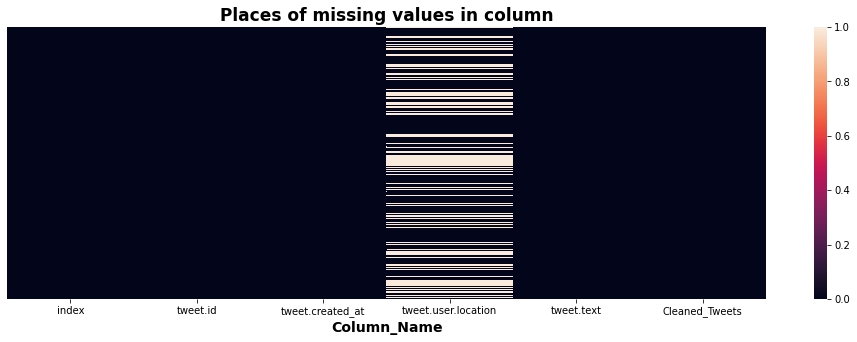

In [ ]:
# Heat Map for missing values
plt.figure(figsize=(17, 5))
sns.heatmap(tweets_cleaned.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

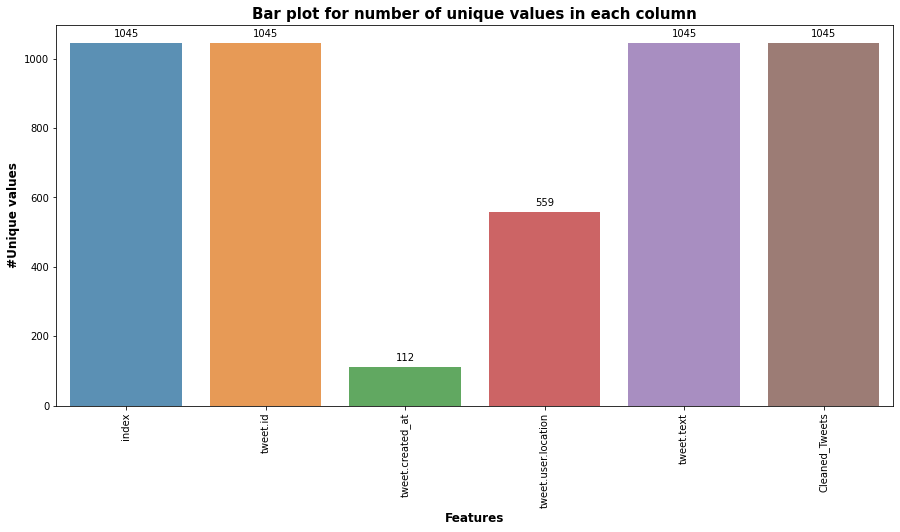

In [ ]:
# Unique Values In Each Feature Coulmn
unique_df = pd.DataFrame()
unique_df['Features'] = tweets_cleaned.columns
unique=[]
for i in tweets_cleaned.columns:
    unique.append(tweets_cleaned[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

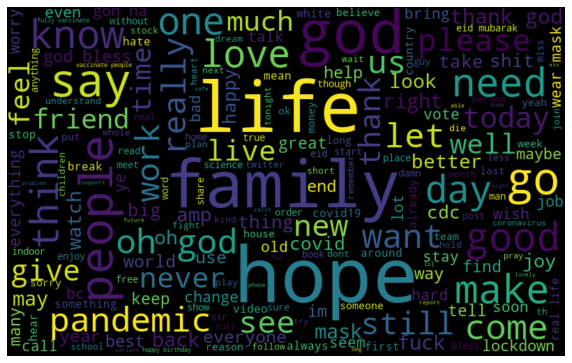

In [ ]:
## Word cloud of cleand tweets
all_words = ' '.join([text for text in tweets_cleaned["Cleaned_Tweets"]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# 4. Vader sentiment:
  1.   Assign vader score and classify them inot a bucket




In [ ]:
pip install vaderSentiment

In [ ]:
tweets_cleaned

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(data,tweet_column_name):
  data['vader_score'] = data[tweet_column_name].apply(lambda x: analyzer.polarity_scores(x)['compound'])

def bucket_vader_score(data,vader_score_column_name):
  data['vader_sentiment_label']= data[vader_score_column_name].map(lambda x:int(1) if x>=0.05 else int(0))

get_vader_score(tweets_cleaned,'Cleaned_Tweets')
bucket_vader_score(tweets_cleaned,"vader_score")

In [ ]:
tweets_cleaned.head()

In [ ]:
anx_list = ['fear','nervous','anxiety','lonely','tightness','faint','breath','hear racing','panic','trembling','swallow','flushed','weak','tingling','fidgety','chest pain']
dep_list = ['hopeless', 'discouraged','lost interest', 'lonely', 'unhappy', 'sad', 'dissatisfied', 'bored','failure','distraught','guilty','irritation','tired','cry','energy','appetite','depression']
anx_dict = dict()
dep_dict = dict()
for i,val in tweets_cleaned.iterrows():
  has_dep = 0
  has_anx = 0
  if(val[6] < 0.0):

    for dep in dep_list:
      if dep in val[5]:
        if dep in dep_dict.keys():
          dep_dict[dep] += 1
        else:
          dep_dict[dep]=1
        has_dep = 1
    tweets_cleaned.at[i,'has_depression'] = has_dep

    for anx in anx_list:
      if anx in val[5]:
        if anx in anx_dict.keys():
          anx_dict[anx] += 1
        else:
          anx_dict[anx] = 1
        has_anx = 1
    tweets_cleaned.at[i,'has_anxiety'] = has_anx

tweets_cleaned['has_depression'] = tweets_cleaned['has_depression'].replace(np.nan, 0)
tweets_cleaned['has_anxiety'] = tweets_cleaned['has_anxiety'].replace(np.nan, 0)
tweets_cleaned

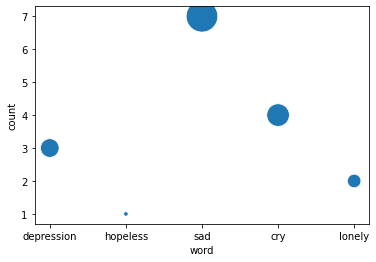

In [ ]:
# libraries
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(dep_dict.items(), columns=['word', 'count'])

# use the scatterplot function to build the bubble map
sns.scatterplot(data=df, x="word", y="count",size="count", legend=False, sizes=(20, 1000))

# show the graph
plt.show()

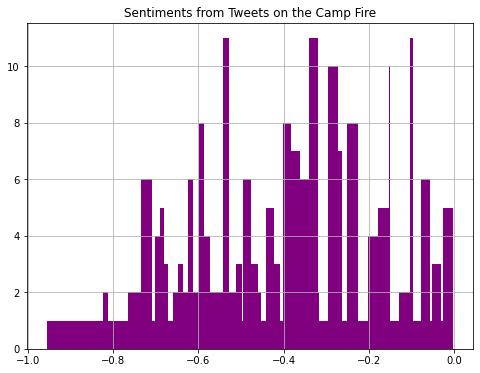

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
neg=tweets_cleaned[tweets_cleaned['vader_score'] < 0]
neg_d=neg['vader_score'].sort_values()
dec = tweets_cleaned['vader_score'].sort_values()

tweets_cleaned['vader_score'].hist(bins=neg_d,ax=ax, color="purple")

plt.title("Sentiments from Tweets on the Camp Fire")
plt.show()

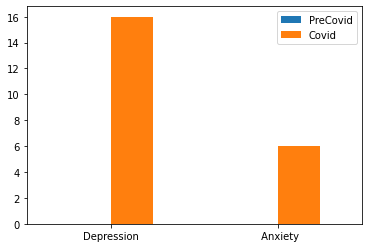

In [ ]:
# Visualization
tweets_cleaned['tweet.created_at'] =  pd.to_datetime(tweets_cleaned['tweet.created_at'])

has_dep_no_covid = 0
has_dep_yes_covid = 0
has_anx_no_covid = 0
has_anx_yes_covid = 0

for i,val in tweets_cleaned.iterrows():
  if val[2].year < 2020:
    has_dep_no_covid += val[8]
    has_anx_no_covid += val[9]
  else:
    has_dep_yes_covid += val[8]
    has_anx_yes_covid += val[9]
  
PreCovid = [has_dep_no_covid,has_anx_no_covid]
Covid = [has_dep_yes_covid,has_anx_yes_covid]
index = ['Depression', ' Anxiety']

df = pd.DataFrame({'PreCovid': PreCovid,'Covid': Covid}, index = index)
ax = df.plot.bar(rot=0)


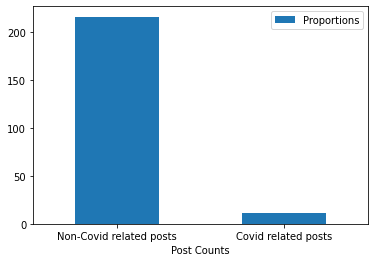

In [ ]:
covid_words = {"COVID2019","COVID19","pandemic","Coronavirus","Social distancing","Flatten the curve", "covid-19", "CORONA", "StayHomeStaySafe", "StayHome", "CovidPandemic", "Lockdown", "Qurantine", "Outbreak"}
cov_count = 0
temp = tweets_cleaned[tweets_cleaned["vader_score"] < 0 ]
for i,val in temp.iterrows():
  for cov in covid_words:
    if cov in val[5]:
      cov_count += 1
      break

non_cov_count = len(temp) - cov_count

df = pd.DataFrame({'Post Counts':['Non-Covid related posts', 'Covid related posts'], 'Proportions':[non_cov_count,cov_count]})
ax = df.plot.bar(x='Post Counts', y='Proportions', rot=0)

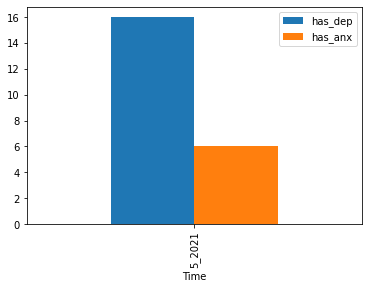

In [ ]:
df = pd.DataFrame()
for i,val in tweets_cleaned.iterrows():
  month = val[2].month
  year =  val[2].year
  df.at[i,'Time'] = str(month)+'_'+str(year)
  df.at[i,'has_dep'] = val[8]
  df.at[i,'has_anx'] = val[9]

ax = df.groupby(by=['Time'])['has_dep','has_anx'].sum()
ax.plot.bar()

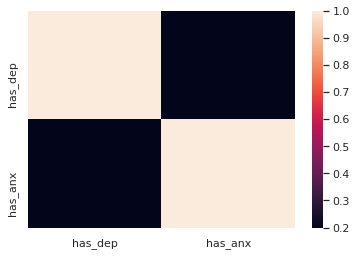

In [ ]:
import seaborn as sns; 
sns.set_theme()
ax = sns.heatmap(df.corr())

#5. Classification Models:
  1.   Decision Tree
  2.   SVM
  3.   Logistic regression
  4.   Random forest



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import numpy as np
from sklearn import preprocessing
from mlxtend.plotting import plot_decision_regions


def get_svd(X_train_vectorized,X_test_vectorized):
  svd = TruncatedSVD(n_components=300, random_state=42)
    #normalization
  X_train_vectorized = preprocessing.normalize(X_train_vectorized, norm='l2')
  X_test_vectorized = preprocessing.normalize(X_test_vectorized, norm='l2')
    #svd
  X_train_vectorized_svd = svd.fit_transform(X_train_vectorized.toarray())
  X_test_vectorized_svd = svd.transform(X_test_vectorized.toarray())
  return X_train_vectorized_svd,X_test_vectorized_svd

def hyperpara_optim(parameters, clf):  
	grid = GridSearchCV(clf,param_grid=parameters,cv=6)
	grid.fit(X_train_vectorized,y_train)
	print('Best parameters:',grid.best_params_,'Best scores:', grid.best_score_)  
	return grid.best_params_

def split_data(df):
	X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Tweets'],df['vader_sentiment_label'], random_state=0)
	vect = TfidfVectorizer(max_features=100000).fit(X_train)
	X_train_vectorized = vect.transform(X_train)
	X_test_vectorized = vect.transform(X_test)
	X_train_vectorized_svd,X_test_vectorized_svd = get_svd(X_train_vectorized,X_test_vectorized)
	return X_train_vectorized_svd,X_test_vectorized_svd,y_train,y_test

def get_confusion_matrix(y_test,y_pred):
  labels = ['Negative', 'Positive']
  cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),columns=["Predicted Negative", "Predicted Positive"],index=["Actual Negative","Actual Positive"])
  cm_df = pd.DataFrame(cm)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax,fmt='g')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  return cm_df

def get_cls_cm(y_test, y_pred,X_test_vectorized,model):
	#check accuracy
  target_names=['0','1']
  print("-----------Classification Report----------")
  cls_report = classification_report(y_test, y_pred, target_names=target_names,output_dict=True)
  cls_report_df = pd.DataFrame(cls_report).transpose()
  print(cls_report_df)
  # make the confusion matrix 
  print("-----------Confusion Matrix----------")
  cm_df = get_confusion_matrix(y_test,y_pred)
  return cls_report_df,cm_df


def get_decision_tree(best_params_dt,X_train_vectorized,X_test_vectorized,y_train,y_test):
	
	clf_dt = DecisionTreeClassifier(max_depth=best_params_dt['max_depth'],min_samples_leaf=best_params_dt['min_samples_leaf'])
	clf_dt.fit(X_train_vectorized,y_train)
	y_pred = clf_dt.predict(X_test_vectorized)
	print('Train score：', clf_dt.score(X_train_vectorized,y_train),'Test score',clf_dt.score(X_test_vectorized,y_test))
	cls_report,cm = get_cls_cm(y_test, y_pred,X_test_vectorized,clf_dt)
	return cls_report,cm,clf_dt

def get_random_forest(best_params_rf,X_train_vectorized,X_test_vectorized,y_train,y_test):
	
	clf_rf = RandomForestClassifier(max_depth=best_params_rf['max_depth'],min_samples_leaf=best_params_rf['min_samples_leaf'])
	clf_rf.fit(X_train_vectorized,y_train)
	y_pred = clf_rf.predict(X_test_vectorized)
	print('Train score：', clf_rf.score(X_train_vectorized,y_train),'Test score',clf_rf.score(X_test_vectorized,y_test))
	cls_report,cm = get_cls_cm(y_test, y_pred,X_test_vectorized,clf_rf)
	return cls_report,cm,clf_rf

def get_svm(best_params_svm,X_train_vectorized,X_test_vectorized,y_train,y_test):
	
	clfrSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
	clf_svm = make_pipeline(StandardScaler(), SVC(C=best_params_svm['C'], gamma=best_params_svm['gamma'], kernel=best_params_svm['kernel']))
	clf_svm.fit(X_train_vectorized,y_train)
	y_pred = clf_svm.predict(X_test_vectorized)
	print('Train score：', clf_svm.score(X_train_vectorized,y_train),'Test score',clf_svm.score(X_test_vectorized,y_test))
	cls_report,cm = get_cls_cm(y_test, y_pred,X_test_vectorized,clf_svm)
	return cls_report,cm,clf_svm

def get_logistic_regression(best_params_lr,X_train_vectorized,X_test_vectorized,y_train,y_test):
  clf_lr = LogisticRegression(C=best_params_lr['C']).fit(X_train_vectorized, y_train)
    # predicting test set results 
  y_pred = clf_lr.predict(X_test_vectorized)
  print('Train score：', clf_lr.score(X_train_vectorized,y_train),'Test score',clf_lr.score(X_test_vectorized,y_test))
  cls_report,cm = get_cls_cm(y_test, y_pred,X_test_vectorized,clf_lr)
  return cls_report,cm,clf_lr

Start processing Logistic Regression
Best parameters: {'C': 1} Best scores: 0.7126541397533764
Train score： 0.8633461047254151 Test score 0.6145038167938931
-----------Classification Report----------
              precision    recall  f1-score     support
0              0.779661  0.343284  0.476684  134.000000
1              0.566502  0.898438  0.694864  128.000000
accuracy       0.614504  0.614504  0.614504    0.614504
macro avg      0.673082  0.620861  0.585774  262.000000
weighted avg   0.675522  0.614504  0.583276  262.000000
-----------Confusion Matrix----------


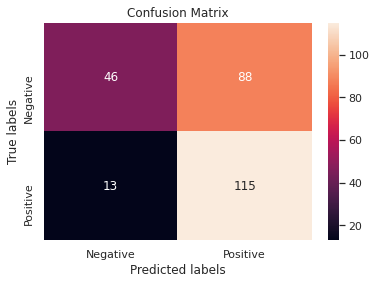

In [ ]:
#get input value for models
X_train_vectorized,X_test_vectorized,y_train,y_test = split_data(tweets_cleaned)

"""Logistic Regression"""
print('Start processing Logistic Regression')
parameters_lr = {'C': [0.1, 1]}
best_params_lr = hyperpara_optim(parameters_lr,LogisticRegression())

cls_report_lr,cm_lr,clf_lr = get_logistic_regression(best_params_lr,X_train_vectorized,X_test_vectorized,y_train,y_test)


Start processing Decision Tree
Best parameters: {'max_depth': 2, 'min_samples_leaf': 1} Best scores: 0.6512624779800352
Train score： 0.685823754789272 Test score 0.5534351145038168
-----------Classification Report----------
              precision    recall  f1-score     support
0              0.729730  0.201493  0.315789  134.000000
1              0.524444  0.921875  0.668555  128.000000
accuracy       0.553435  0.553435  0.553435    0.553435
macro avg      0.627087  0.561684  0.492172  262.000000
weighted avg   0.629438  0.553435  0.488133  262.000000
-----------Confusion Matrix----------


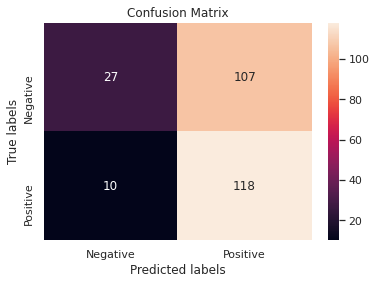

In [ ]:
#get input value for models

"""Decision Tree"""
print('Start processing Decision Tree')
parameters_dt = { 'max_depth': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]}
best_params_dt = hyperpara_optim(parameters_dt,DecisionTreeClassifier())

cls_report_dt,cm_dt,clf_dt = get_decision_tree(best_params_dt,X_train_vectorized,X_test_vectorized,y_train,y_test)


Start processing SVM
Best parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} Best scores: 0.7355940497161871
Train score： 1.0 Test score 0.7557251908396947
-----------Classification Report----------
              precision    recall  f1-score     support
0              0.753623  0.776119  0.764706  134.000000
1              0.758065  0.734375  0.746032  128.000000
accuracy       0.755725  0.755725  0.755725    0.755725
macro avg      0.755844  0.755247  0.755369  262.000000
weighted avg   0.755793  0.755725  0.755583  262.000000
-----------Confusion Matrix----------


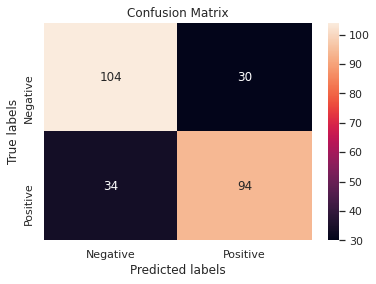

In [ ]:
#get input value for models

"""SVM"""
print('Start processing SVM')
parameters_svm = {'C': [10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
svc = svm.SVC()
best_params_svm = hyperpara_optim(parameters_svm,svc)

cls_report_svm,cm_svm,clf_svm = get_svm(best_params_svm,X_train_vectorized,X_test_vectorized,y_train,y_test)


Start processing Random Forest
Best parameters: {'max_depth': 10, 'min_samples_leaf': 5} Best scores: 0.7074476414171071
Train score： 0.9859514687100894 Test score 0.5916030534351145
-----------Classification Report----------
              precision    recall  f1-score     support
0              0.787234  0.276119  0.408840  134.000000
1              0.548837  0.921875  0.688047  128.000000
accuracy       0.591603  0.591603  0.591603    0.591603
macro avg      0.668036  0.598997  0.548443  262.000000
weighted avg   0.670765  0.591603  0.545246  262.000000
-----------Confusion Matrix----------


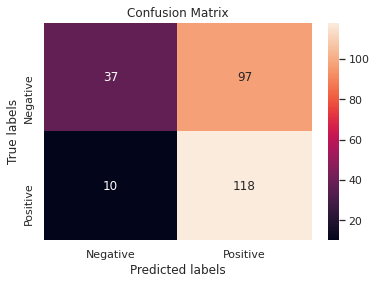

In [ ]:
#get input value for models

"""Random Forest"""
print('Start processing Random Forest')
parameters_rf = { 'max_depth': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]}
best_params_rf = hyperpara_optim(parameters_rf,RandomForestClassifier())

cls_report_rf,cm_rf,clf_rf= get_random_forest(best_params_rf,X_train_vectorized,X_test_vectorized,y_train,y_test)


#7. Model analysis and run on test data:
1.   Model analysis




AUC for Logistic Reg = 0.795
AUC for Decision Tree = 0.675
AUC for Random Forest = 0.760
AUC for SVM = 0.822


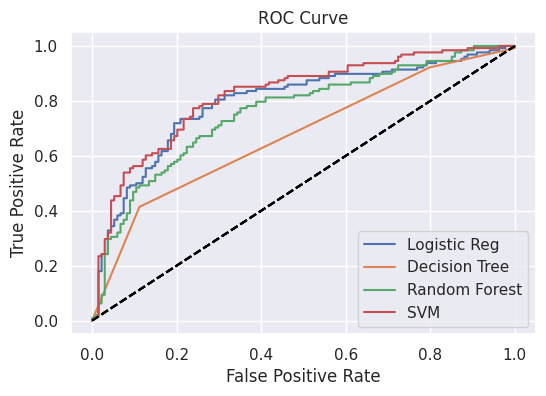

In [ ]:
def get_model_roc(models, Xs_test, names, Y_test):
    plt.rcParams['figure.dpi'] = 100
    for i in range(len(models)):
        model = models[i]
        X_test = Xs_test[i]
        name = names[i]
        if i == 3 :
          probs = clf_svm.decision_function(X_test_vectorized)
        else:
          probs = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, probs)
        plt.plot(fpr, tpr, label=name)
        plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        print ("AUC for {0} = {1:.3f}".format(name, metrics.roc_auc_score(Y_test, probs)))
    plt.legend()
    plt.show()

get_model_roc([clf_lr,clf_dt,clf_rf,clf_svm], [X_test_vectorized,X_test_vectorized,X_test_vectorized,X_test_vectorized], ['Logistic Reg','Decision Tree','Random Forest','SVM'], y_test)

# 8. Project Outcomes